# Przewidywanie spożycia alkoholu przez studentów z wykorzystaniem prostej sieci neuronowej
## Analiza Zbioru danych
Dane omawiane w niniejszym dokumencie pobrane są ze strony https://www.kaggle.com/uciml/student-alcohol-consumption  
Zawierają one wyniki ankiety przeprowadzonej pośród studentów dwóch kursów: matematyki oraz portugalskiego. Podczas ankiety zebrano wiele danych o respondentach takie jak, wiek, oceny, rozmiar rodziny, czy też średnie spożycie alkoholu, które będzie przedmiotem niniejszej analizy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output

math_class_data = pd.read_csv(os.path.abspath('') + "/data/student-mat.csv", delimiter=";")
port_class_data = pd.read_csv(os.path.abspath('') + "/data/student-por.csv", delimiter=";")
data = math_class_data.append(port_class_data)
data = data[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob','Fjob','reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
            'Walc', 'health', 'absences', 'G1', 'G2', 'G3']]
numeric_values = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                  'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
binary_values = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
                 'famsup', 'paid', 'higher', 'activities', 'nursery', 'internet', 'romantic']
nominal_values = ['reason', 'guardian','Mjob','Fjob']
data


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


Pozwoliliśmy sobie na połączenie danych z dwóch kursów, ponieważ różnice wynikające z możliwych różnic w poziomach trudności (a co za tym idzie ocen) sa minimalne.  
  
Dane ną pełne, nie ma tu pustych komórek, co ułatwi trening sieci.  
Mamy tu ponad 1000 rekodrów, co wg informacji z wykładu powinno pozwolić na wytrenowanie sieci zawierającej (w przubliżeniu) do 100 neuronów.

W zbiorze danych mamy do czynienia z dwoma typami parametrów:
- liczbowe - wiek, wyniki ocen
- binarne - wsparcie rodziny, branie dodatkowych aktywności
- nominalne - płeć, miejsce zamieszkania, powód wybrania kursu

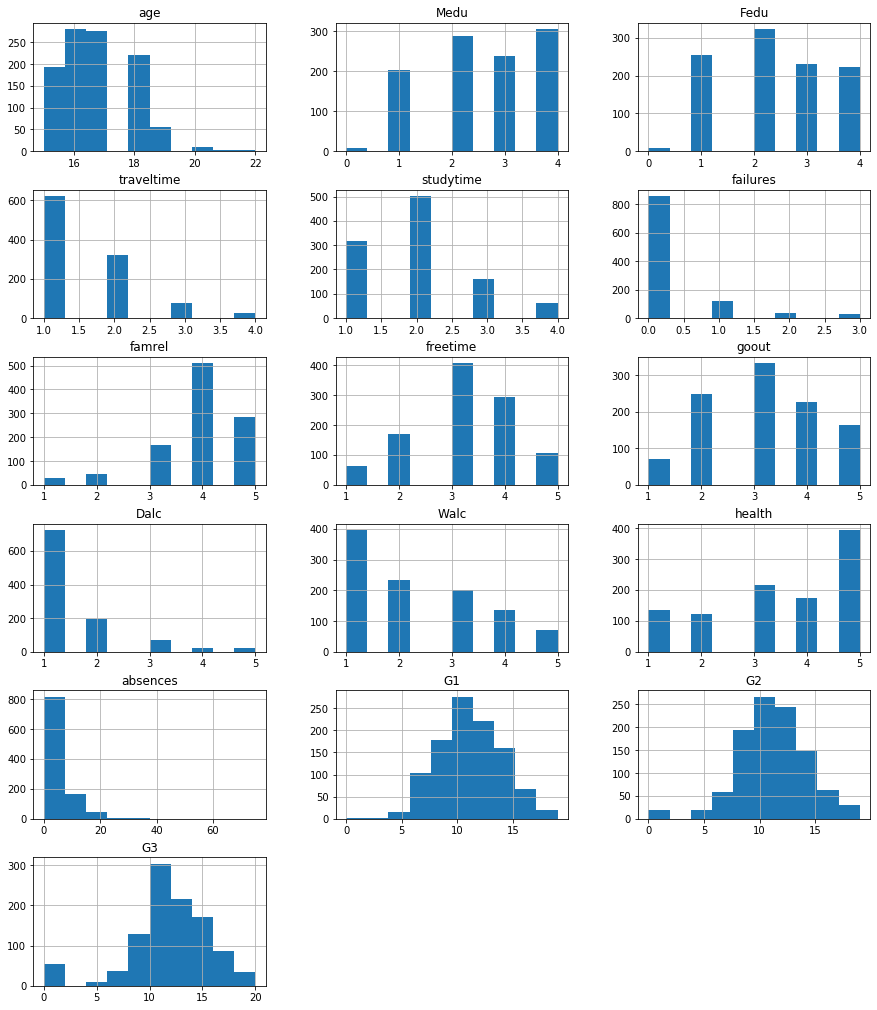

In [2]:
x = data[numeric_values].hist(figsize=(15,30),ylabelsize=10,layout=(10,3))

W wypadku histogramów dla wartości numerycznych można zauważyć, że w wielu wypadkach ich rozkład odpowiada rozkładowi normalnemu.

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 3 * nGraphRow), dpi = 80)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

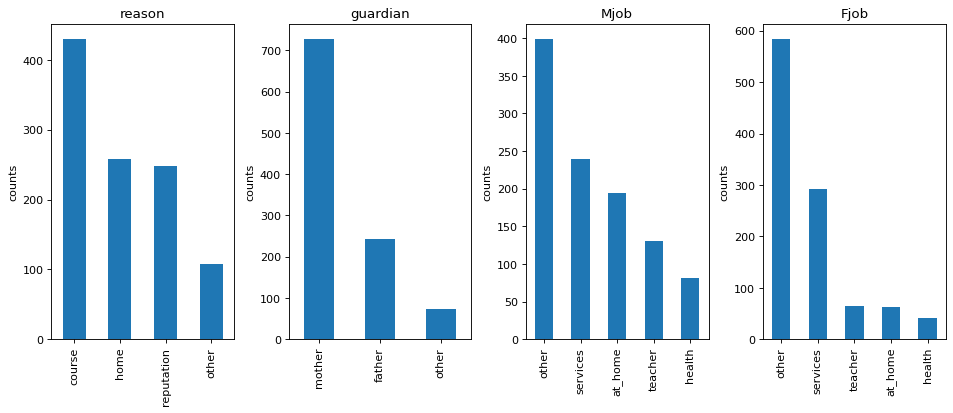

In [4]:
plotPerColumnDistribution(data[nominal_values],4,4)

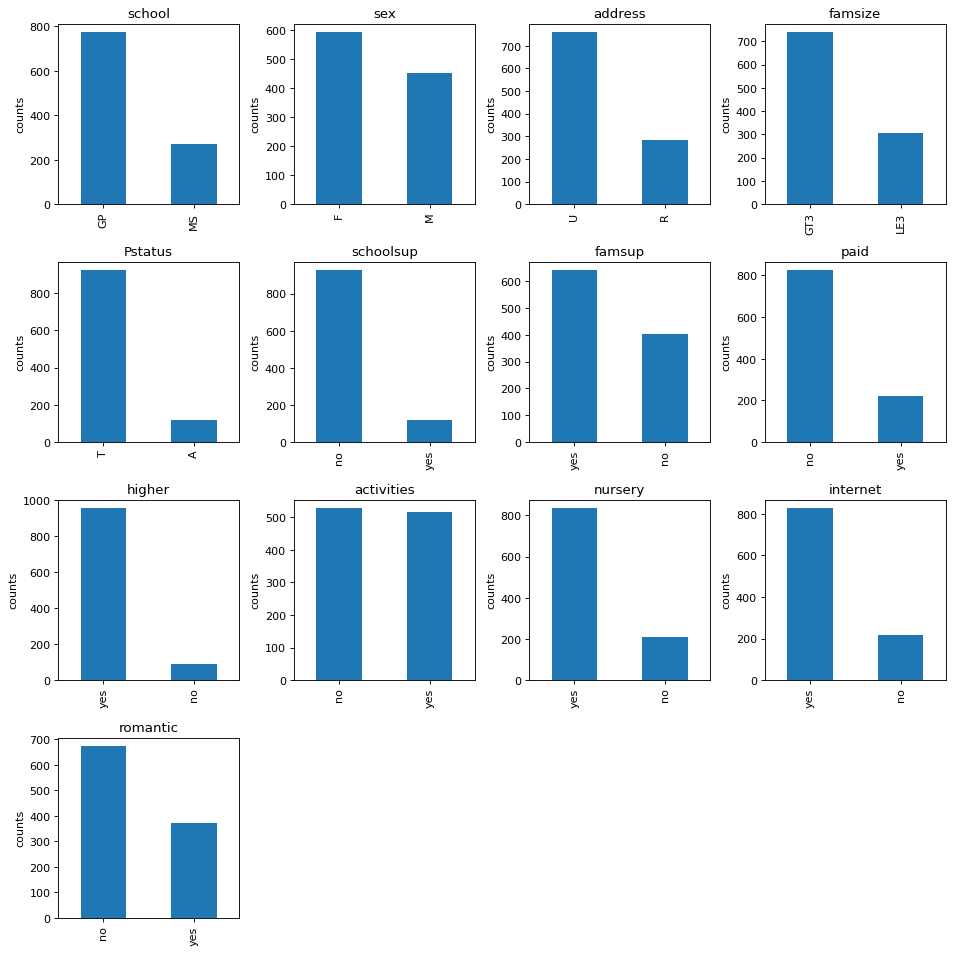

In [5]:
plotPerColumnDistribution(data[binary_values], len(binary_values), 4)

<AxesSubplot:>

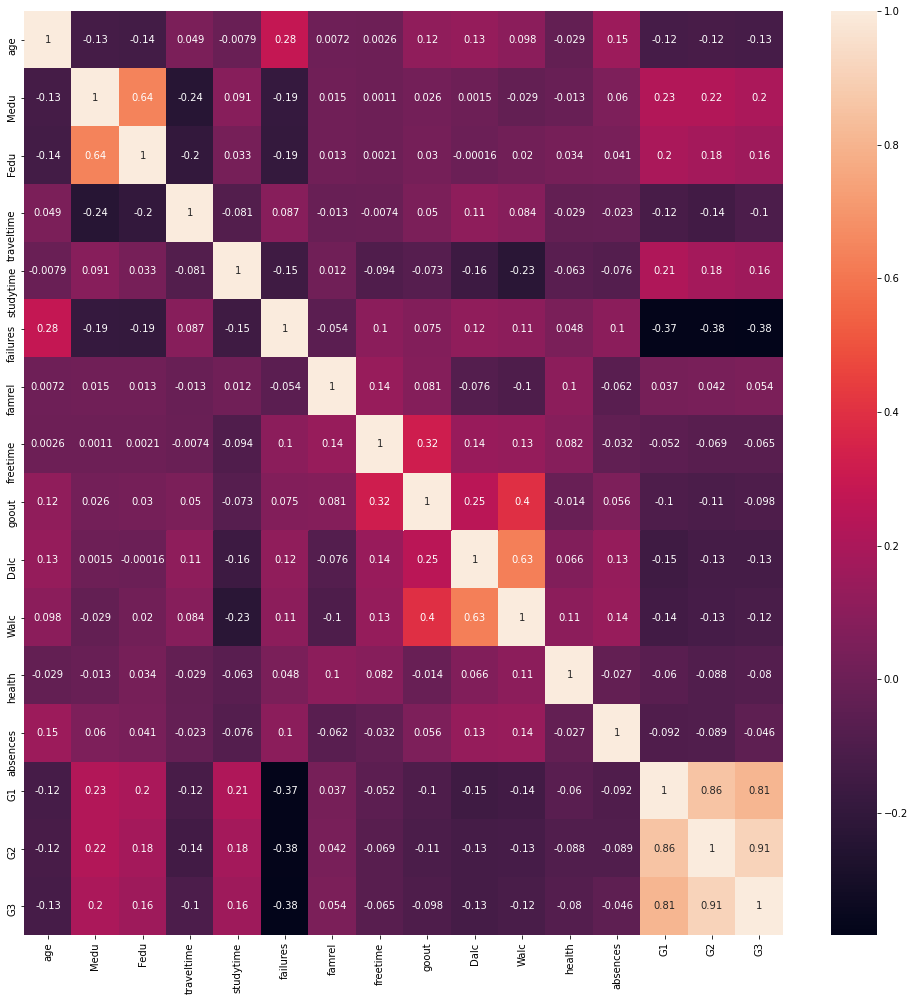

In [6]:
import seaborn as sns
plt.figure(figsize=(17,17))
sns.heatmap(data.corr(),annot = True)

Z powyższej mapy korelacji można wywnioskować pewne prostsze zależności dotyczące spożycia alkoholu wśród uczestników kursu.  
Można zauważyć, że spożycie alkoholu jest proporcjonalne do częstotliwości wyjść, zaś odwrotnie proporcjonalne do ilości czasu spędzonego na nauce.

## Uczenie stworzonej sieci

Przewidywanie spożycia alkoholu wśród studentów biorących udział w kursie potraktujemy jako problem klasyfikacji, w ramach którego postaramy sie przyporządkować studentów do odpowiednich grup.

W pierwszym kroku importujemy oraz konwertujemy dane do formatu zalecanego dla sieci neuronowych, te z danych wejściowych, które mają wartości liczbowe zostały przeskalowane, tak, aby ich średnia wynosiła 0, a odchylenie standardowe 1, dane binarne zostały przekonwertowane na zera i jedynki, a dane opisujące klasy zostały podzielone za pomocą metody One Hot Spot.
Dane wyjściowe także zostały przekonwertowane z wykorzystaniem tej metody.

Dodatkowo podzieliśmy dane na dwa zbiory:  
- treningowy, którego dane będą wykorzystane do uczenia sieci
- testowy, który będzie wykorzystany do walidanci efektów uczenia sieci

In [7]:
from application import *
from sklearn.model_selection import train_test_split
d = DataClass()

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(d.data_to_network, d.output_walc, test_size=0.2)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(d.data_to_network, d.output_dalc, test_size=0.2)
d.data_to_network

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher
0,1.027397,1.241482,1.465600,0.651898,0.035589,-0.402913,0.068755,-0.195005,0.732161,-0.381205,...,1,0,0,0,0,0,0,0,0,1
1,0.220929,-1.425406,-1.261827,-0.714731,0.035589,-0.402913,1.140106,-0.195005,-0.135462,-0.381205,...,1,0,0,0,0,0,0,1,0,0
2,-1.392007,-1.425406,-1.261827,-0.714731,0.035589,4.169270,0.068755,-0.195005,-1.003085,-0.381205,...,1,0,0,0,0,0,0,1,0,0
3,-1.392007,1.241482,-0.352684,-0.714731,1.234122,-0.402913,-1.002596,-1.164461,-1.003085,1.022596,...,0,1,0,0,0,0,0,0,1,0
4,-0.585539,0.352520,0.556458,-0.714731,0.035589,-0.402913,0.068755,-0.195005,-1.003085,1.022596,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1.833865,-0.536443,0.556458,-0.714731,1.234122,1.121148,1.140106,0.774450,-1.003085,1.022596,...,0,0,0,1,0,0,0,1,0,0
1040,1.027397,0.352520,-1.261827,-0.714731,0.035589,-0.402913,0.068755,-0.195005,0.732161,-1.785006,...,0,0,0,0,1,0,0,0,1,0
1041,1.027397,-1.425406,-1.261827,0.651898,0.035589,-0.402913,-3.145298,-2.133916,-1.870708,1.022596,...,0,0,1,0,0,0,0,1,0,0
1042,0.220929,0.352520,-1.261827,0.651898,-1.162945,-0.402913,-2.073947,0.774450,1.599783,-1.083105,...,0,0,0,1,0,0,0,0,1,0


W następnym kroku tworzymy dwie sieci neuronowe, określamy ich wymiary wejściowe, wyjściowe oraz ilość i wymiary poszczególnych warstw wewnętrznych.

In [16]:
nn_walc = NeuralNetwork(d.get_num_of_columns(),[20],5, "relu")
nn_dalc = NeuralNetwork(d.get_num_of_columns(),[20],5, "relu")

Teraz możemy przejść do właściwego treningu sieci neuronowej.
Na tym etapie dobieramy takie kluczowe parametry jak:
- liczba epok
- *batch_size* - opisujący w jakich grupach będą podzielone nasze próbki
- *learning_rate* - współczynnik regulujący wielkość kroku naszej funkcji

In [17]:
epochs_number = 1000
print("Walc")
nn_walc.train(train_data=X_train_w,targets=y_train_w,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)
print("Dalc")
nn_dalc.train(train_data=X_train_d,targets=y_train_d,epochs=epochs_number,batch_size=10,learning_rate=0.001,number_of_prints=5)

Walc
epochs: 200 ==== error: 0.24493695513490352
epochs: 400 ==== error: 0.23446548275472917
epochs: 600 ==== error: 0.2295781138609651
epochs: 800 ==== error: 0.22661419351975645
epochs: 1000 ==== error: 0.2247442970846419
Dalc
epochs: 200 ==== error: 0.16058738434373468
epochs: 400 ==== error: 0.15560424023054656
epochs: 600 ==== error: 0.15311634192501256
epochs: 800 ==== error: 0.15079639886850713
epochs: 1000 ==== error: 0.14868235698222576


In [18]:
print("Dokładność przeiwdywań dla weekendowego spożycia:",round(nn_walc.test(np.asarray(X_test_w),np.asarray(y_test_w))*100,4),"%")
print("Dokładność przeiwdywań dla dziennego spożycia:",round(nn_dalc.test(np.asarray(X_test_d),np.asarray(y_test_d))*100,4),"%")

Dokładność przeiwdywań dla weekendowego spożycia: 44.0191 %
Dokładność przeiwdywań dla dziennego spożycia: 70.3349 %


Dla dobranych parametrów nauczania udało się uzyskać przewidywanie sieci z dokładnością w okolicach 45% dla weekendowego spożycia oraz 75% dla dziennego, co nie jest zbyt dobrym wynikiem, zwłaszcza biorąc pod uwagę to, że zbliżone wyniki można uzyskać po prostu zawsze zwracając wartość najczęściej pojawiającą się w zbiorze ( w tym wypadku 1 dla obu zbiorów).   
Taki wynik może świadczyć o braku prostych korelacji pomiędzy poszczególnymi parametrami, bądź też o niewłaściwym doborze parametrów/konfiguracji sieci.

Z tego powodu zdecydowaliśmy się na zbadanie tych danych także za pomocą innej, gotowej implementacji sieci neuronowej.

In [20]:
from sklearn.neural_network import MLPClassifier
clf_w = MLPClassifier(random_state=1, max_iter=epochs_number).fit(X_train_w, y_train_w)
print("Dokładność przwidywań dla weekendowego spożycia:", round(100*clf_w.score(X_test_w, y_test_w),3),"%")
clf_d = MLPClassifier(random_state=1, max_iter=epochs_number).fit(X_train_d, y_train_d)
print("Dokładność przwidywań dla dziennego spożycia:", round(100*clf_d.score(X_test_d, y_test_d),3),"%")

Dokładność przwidywań dla weekendowego spożycia: 50.718 %
Dokładność przwidywań dla dziennego spożycia: 76.077 %


Okazuje się, że w wypadku gotowej sieci wyniki są porównywalne z wynikami uzyskanymi za pomocą naszej implementacji sieci neuronowej.  
W związku z tym możemy założyć, że dla badanego zbioru nie można dokładnie przewidzieć spożycia alkoholu w badanej grupie.

Dla wygody 

Mapa błędów dla weekendowego spożycia


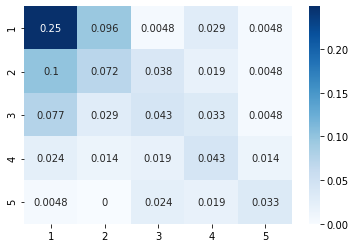

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

walc_predict = nn_walc.predict(X_test_w, True)
confusion_w = confusion_matrix(list(y_test_w.idxmax(axis=1)-1), list(walc_predict))
print("Mapa błędów dla weekendowego spożycia")
tmp = sns.heatmap(confusion_w/np.sum(confusion_w), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])


Mapa błędów dla dziennego spożycia


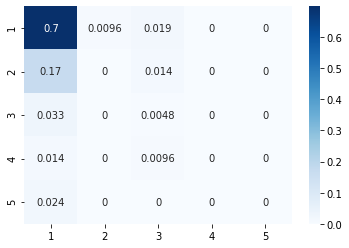

In [22]:
dalc_predict = nn_dalc.predict(X_test_d, True)
confusion_d = confusion_matrix(list(y_test_d.idxmax(axis=1)-1), list(dalc_predict))
print("Mapa błędów dla dziennego spożycia")
tmp = sns.heatmap(confusion_d/np.sum(confusion_d), cmap="Blues", annot=True, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

Pokazane powyżej mapy błędów tylko potwierdzają nasze spostrzeżenia, zwłaszcza w pzypadku badaniu spozycia dziennego, gdzie widać, że algorytm podaje na ogół wartość 1 dla danych wejściowych.   
W wypadku danych dla weekendowego spozycia sytuacja wydaje się być nieco lepsza, ponieważ model operuje także na pozostałych wartościach z zakresu 1-5. W prawdzie szansa na uzyskanie wtedy poprawnej wartości wcale nie jest duża, ale przynajmniej nie jest zerowa jak to jest w przypadku tygodniowego spożycia.

## Wnioski
Wygląda na to, że w badanym zbiorze danych nie da się łatwo przewidzieć spożycia alkoholu na podstawie pozostałych danych, w prawdzie w niektórych przypadkach można uzyskać rezultaty wykraczające poza rachunek prawdopodobieństwa, ale jest to najczęściej spowodowane "lenistwem" sieci, która po prostu prawie zawsze wybiera wartość najczęściej występującą w zbiorze, co pozwala dość łatwo uzyskać dobry rezultat w dużej części przypadków.  
Zaobserwowaliśmy także, że w wypadku z bardziej zróżnicowanym zbiorem danych (spożycie weekendowe) to zjawisko było nieco mniej odczuwalne. Może to oznaczać, że w niektórych przypadkach warto zastanowić się nad ograniczeniem liczebności grupy dominującej w naszym zbiorze, co mogłoby ograniczyć skutki tego zjawiska.
 
Zauważyliśmy też problem z eksplodującym gradientem. Należy więc ostrożnie dobierać wielkość learning_rate i batch_size. Żeby ograniczyć wpływ zastosowaliśmy nasycenie funkcji ReLU do maksymalnej wartości 50. Gdybyśmy zastosowali regularyzacje L2 możliwe że dałoby się całkowicie ominąć ten problem.

### Czego się nauczyliśmy

Dzięki realizacji tego projektu poprawiliśmy naszą znajomość:
- zasad działania oraz budowy sieci neuronowych
- narzędzi do analizy oraz obróbki danych
- składni oraz specyfiki języka Python